# Summary of this Notebook

In this notebook, we develop our production model for predicting the outcome of a new player on Lichess.org's 2nd game.  Our production model is a depth-5 neural network that uses move data from a new player's first game along with metadata about her 1st and 2nd games and her 2nd-game opponent's most recent previous game.

We begin this notebook by explaining our modeling process, which uses the move data to construct two sets of scores: the *absolute goodness* scores of the various positions achieved during the game, as well as the *relative goodness* of the moves selected by the new player.  We then fit our model on the move data and the other metadata, selecting our production model as the version with lowest BCE loss on the test data.  For comparison, we create an additional baseline neural network model that is trained on the *metadata only* and not on the move data.  We then use our untouched validation data to compare our production model to our baseline models, and we explore the performance of our production model.

***This notebook was prepared with significant help from Halley Young in converting abstract modeling ideas to concrete PyTorch modules.***

## Instructions

1. Run `pip install lion_pytorch`.  This package provides a better optimizer than the default ones in PyTorch.
2. If you don't want to train models for yourself, you can load them in from the [models folder](../models).  Indeed, this notebook loads in the saved models by default; to train the models yourself and keep your trained versions, simply un-comment the code that saves the models after training.

## Imports

In [112]:
import pickle
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from lion_pytorch import Lion

from sklearn import metrics
import matplotlib.pyplot as plt

# Our model: the main ideas

Our model's goal is to predict the outcome of a new player's 2nd-ever game on Lichess.org using both *non-move-related metadata* and *the move data from the new player's 1st game*.  Existing models like Elo and Glicko use only the metadata; for example, Elo uses the *ratings* of the two players to predict the outcome of their game.  Our goal is to incorporate not only these metadata but also information from the *actual moves of the new player's 1st game*.

To accomplish this, we asked Stockfish to record two types of information from each new player's 1st game:
1. The "evaluation" score of each position achieved during the game.  These are measured in "centipawns" (numeric) or in "moves until checkmate" (categorical).  Our model learns an *embedding* of the categorical values into a 1-dimensional continuous space; thus, the "Mate" scores are also converted to be on a numeric scale (see below).
2. The "top 10 moves" available to the new player during each of the new player's turns (with a Centipawn or Mate score for each move).

Note that since the new player moves only *every other* turn of the game, the number of turns for which we have "evaluation" scores will be about twice as many as the number of turns for which we have "top 10 moves" scores.

We need a way of condensing this large amount of information down into a smaller number of variables that can be fed into a neural network model along with the non-move-related metadata.  We do this by extracting two sets of scores that summarize the new player's performance in her 1st game.  For each *tenth* of each game, we extract:
- the average *absolute goodness score* of the positions achieved during that tenth of the game, and
- the average *relative goodness score* of the moves made by the new player during that tenth of the game.

The *absolute goodness score* of a position is simply Stockfish's evaluation of that position, with its sign changed so that positive numbers indicate that the *new player* (rather than the White player) is winning and negative numbers indicate that the new player is losing.  So in an example game lasting 59 moves (i.e. 60 positions) where the new player is playing White, the new player's absolute goodness (AG) score for the first tenth of the game is simply the mean of the Stockfish evaluation scores of the first 6 positions achieved during the game; her AG score for the 2nd tenth of the game is the average Stockfish evaluation of positions 7-12, etc.

The 10 "absolute goodness scores" are meant to capture the overall strength of the new player's performance in each 10th of her 1st game.  For example, if a new player wins her 1st game (against an opponent with a 1500 rating, say), our prediction of how well that player will do against a certain opponent in her next game might depend greatly on whether the new player had a *dominating victory* in her 1st game or *barely won* her 1st game.  Looking at the new player's AG scores might help us determine the strength of her victory.  Furthermore, breaking these scores up into "tenths of the game" allows our model to learn patterns in the finer-grained information: for example, perhaps players who have strong openings and weak endgames are "worse" than players who have weak openings but strong endgames, even when controling for the overall average AG score across all 10 tenths of the game.

The 10 "relative goodness scores" are meant to capture how well the new player *selects good moves from the moves available to her*.  The relative goodness score of each of the new player's moves is computed using a method explained below; essentially, it compares the actual move she made to some combination of the 10 best moves available to her (as determined by Stockfish).  These per-move scores are then averaged across each tenth of the game: in our 59-move (60-position) game above, the new player's RG score for the first tenth of the game is computed by comparing the moves that the new player made on positions 0, 2 and 4 to the top 10 moves she could have made on these positions and then averaging these results.  Her score for the 2nd tenth of the game is similarly computed by comparing her moves on positions 6, 8 and 10 to the top 10 available each position, etc.

Why might we care about *relative goodness scores* rather than just *absolute goodness scores*?  Imagine that two otherwise-equivalent new players each play their first game against a very strong opponent who defeats each new player in commanding fashion.  On average throughout the game, New Player A generally selects the 3rd-best move available to her, while New Player B generally selects the 2nd-best move available to her.  In this case, an experienced observer might easily determine that New Player B is significantly more skilled at chess than New Player A is.  However, because the opponent is so much stronger, both players' *absolute* goodness scores achieved throughout the game are somewhere in the bottom 10 percentile of AG scores of new players - say, A's are at the bottom 5% while B's are at the bottom 8%.  Thus, although B is actually *significantly* more skilled than A, a model that only looks at *absolute* goodness scores might become convinced that B is only *very slightly* more skilled than A.

Since the *relative* goodness scores capture the fact that B generally selects better moves than A does, including these as features in our neural network model allows the model to make better predictions about how new players will fare in their 2nd games - particularly in cases like the example above.


## The "relative goodness score" of a move

How do we obtain a "relative goodness score" for each of the new player's moves?  Stockfish merely provides a list of the *top 10 moves* that the new player *could have made* on each of her turns (along with the evaluation scores of the positions that would result next turn from making each of those 10 moves), as well as an evaluation score of the position achieved by the new player's *actual* move.  It does not report a "relative goodness score."

Our main idea of how to obtain a "relative goodness score" is to compare the score of the position *actually* reached after the player's move with the scores of the "top 10" positions that *could have been reached if she made a certain move*.  For example, if the player made a move that achieved a score $S_{actual}$ on the next position and Stockfish thought that the highest-score move she *could have made* has a score of $S_1$ and the 10th-highest-score move she could have made has a score of $S_{10}$, then one sensible "relative goodness score" might be
$$ R_{top10} = \frac{S_{actual} - S_{10}}{S_1 - S_{10}}. $$
That is, $R_{top10}$ measures how good the *actual move* was on a scale of "10th best move available" to "best move available" (according to Stockfish).

One issue with an approach like the above is: Why judge a move's relative goodness on a scale of 10th-best move to best move rather than on a scale of, say, 5th-best move to best move?  We could just as well use
$$ R_{top5} = \frac{S_{actual} - S_{5}}{S_1 - S_{5}}, $$
and perhaps this would be a more reasonable measure of the "relative goodness" of the player's move.  Indeed, in many chess positions, only a few moves are even potentially viable, while many moves can be so obviously bad that even a novice player would essentially never choose them.

As an example illustrating the difficulty of determining which moves were the player's "reasonable alternatives," consider a situation in which the top 3 moves have scores of 500, 300 and 200 respectively, while the 5th-best move has a score of 100 and the 10th-best move has an abysmal score of -500.  Suppose the player selected the 2nd-best move (absolute score = 300).  If we used $R_{top10}$ to evaluate the player's move, the move's "relative goodness score" would be
$$ R_{top10} = \frac{300 - (-500)}{500 - (-500)} = 0.8,$$
i.e. we're essentially saying that "Among the reasonable moves available to her, the player made a move that is 80% as good as the best move." If instead we used $R_{top5}$, then her move's relative goodness score would be
$$ R_{top5} = \frac{300 - 100}{500 - 100} = 0.5,$$
so we're saying that "Among the reasonable moves available to her, the player made a move that is 50% as good as the best move."  Finally, if instead we used $R_{top3}$, then her move's relative goodness score would be
$$ R_{top3} = \frac{300 - 200}{500 - 200} = 0.333,$$
so we're saying that "Among the reasonable moves available to her, the player made a move that is 33.3% as good as the best move."  As we can see, our "relative goodness score" of the player's move varies wildly depending on whether we consider the "resaonable" moves to be the top 10, the top 5, or merely the top 3.

Thus, it is not obvious what the best threshold should be for the set of "reasonable moves available."  This problem is further complicated by the fact that the proper threshold might change from move to move, or at least between different "stages of the game."

How might we get around this problem?  Instead of using an *absolute range of moves* (say, "the reasonable moves are always the top 5") and comparing the player's move to the top and bottom scores in the allowed range, our model will compare the score of the actual move the player made to a *weighted average* of the scores of *all* the top 10 moves available.  Furthermore, the weights used in this average are allowed to change between different "stages" (in our case, tenths) of the game.  We then let our neural network model *learn* how to weight each of the top 10 moves at each of the 10 different stages of the game.

Formally, our model has a 10x10 matrix of "weights" $w_{i,j}$ for the top 10 moves available.  If the $t$-th move made by a new player occurs during a the $i$-th tenth of the game, the "relative goodness score" of that move is
$$ R_t = \frac{S_{actual} - (w_{i,1}S_1 + w_{i,2}S_2 + \ ... \ + w_{i,10}S_{10})}{w_{i,1}S_1 + w_{i,2}S_2 + \ ... \ + w_{i,10}S_{10}} = \frac{S_{actual}}{w_{i,1}S_1 + w_{i,2}S_2 + \ ... \ + w_{i,10}S_{10}} - 1 $$
where $S_1, \ ... \ S_{10}$ are the scores of the top 10 moves available and $S_{actual}$ is the score of the move the player actually made.

In this way, if it turns out that in the first tenth of the game only the top 6 moves are generally relevant, then we should expect $w_{1,1}$ through $w_{1,6}$ to be nonzero but $w_{1,7}$ through $w_{1,10}$ to be close to 0.  If it turns out that in the final tenth of the game only the top 3 moves are generally relevant, then we should expect $w_{10,1}$ through $w_{10,3}$ to be nonzero but $w_{10,4}$ through $w_{10,10}$ to be close to 0.  This is how the model can "learn" something analogous to the answer to "How many of the top 10 available moves are reasonable ones, at each stage of the game?"

Another way of thinking about this is that at each stage (tenth) $i$ of the game, the model learns how to "set its expectations of the scores of reasonable moves" by learning the weights $w_{i,1}, \ ... \ , w_{i,10}$ to put on the top 10 moves available.  Given the values for these weights, the "relative goodness score" of a move will be *positive* if the move was *better* than what the model has learned to "expect" at that stage of the game and will be negative if the move was worse than expected.  Better moves yield stronger positive values, and worse moves yield stronger negative values.

## Why only look at the top 10 moves available?  Why not the top 20 or *all* moves available?

If we are allowing the model to figure out how to weight the *top 10 moves available*, then why not allow it to figure out how to weight the *top 20 moves available* instead?  We view this as unnecessary: in nearly all chess positions, fewer than 10 moves are even remotely reasonable.  Even though there can be rare scenarios where more than 10 moves are viable, since these scenarios are so rare, the model is likely to learn weights that essentially ignore moves outside the top 10.  Thus, including more than the top 10 moves is unlikely to yield much improvement, but it would come at a substantially increased compuational cost - particularly to Stockfish, but also to our neural network model.

We chose "top 10" as our threshold of moves for which to request Stockfish evaluations in order to give ourselves a reasonable-but-not-excessive amount of "breathing room."  Although some stages of the game may tend to have far fewer than 10 reasonable moves available, we asked Stockfish to evaluate all of the top 10 moves.  This way, even at stages of the game with an abnormally large number of reasonable moves available, we were likely to have captured all of the "reasonable moves" within the top 10.

## "Mate" Scores and Embeddings

As mentioned above, Stockfish reports the evaluations of some positions as "moves until checkmate" scores rather than "centipawn" scores.  While Centipawn scores are naturally on a linear scale, Mate scores are not.  For example, the difference (in terms of how well a human playing White is doing) between a "Mate in 10" position and a "Mate in 9" position is probably nowhere near as large as the difference between a "Mate in 3" position and a "Mate in 2" position.

For this reason, we thought it appropriate to treat the different possible Mate scores (ranging from "White has mate in 15" to "Black has mate in 15") as *categorical* values and let the model learn an *embedding* of these values into 1-dimensional continuous space.  Doing so allows these Mate scores to be converted so as to be on the same scale as the Centipawn scores, which allows our model to treat the two types of scores interchangeably.

Furthermore, since we are treating "Mate" scores as categorical values for which to learn an embedding, we are also free to include additional categories.  As mentioned in the [last notebook](./04_baseline_models.ipynb), when getting the evaluation of a *final board position where the game has ended* (not due to an early concession), we encode "checkmate by new player", "checkmate by opponent", "stalemate by new player", "stalemate by opponent", and "draw due to insufficient material" each as its own distinct value of "Mate".  This allows for more granularity than if we left all of these as their Stockfish evaluation values, *all* of which are simply called "Mate in 0" (with no specification of who has done the "Mate", or whether it's a checkmate or stalemate).

# Creating PyTorch Datasets

### Load the pickled dictionaries of all data

In [26]:
#Training data
data_dict = pickle.load(open("../data/sf_evals/train.pcl", "rb"))
#For easily examining what the values look like
data_dicts_list = list(data_dict.values())

#Test and val data
test_data_dict = pickle.load(open("../data/sf_evals/test.pcl", "rb"))
val_data_dict = pickle.load(open("../data/sf_evals/val.pcl", "rb"))

In [27]:
#What does a single observation's data look like?
data_dicts_list[0]

{'data': [0,
  1.0,
  1417.0,
  138.0,
  -6.0,
  65,
  480.0,
  5.0,
  0,
  0,
  0,
  1500.0,
  1608.0,
  360.0,
  0.0,
  0,
  1,
  0.0,
  1612.0,
  1882.0,
  -4.0,
  4.0,
  55,
  300.0,
  4.0,
  0,
  1,
  0,
  0],
 'target': 1.0,
 '1st_game_positions': [{'eval': {'is_mate_score': 0, 'cp': 64, 'mate': 0},
   'top10': [{'is_mate_score': 0, 'cp': 70, 'mate': 0},
    {'is_mate_score': 0, 'cp': 39, 'mate': 0},
    {'is_mate_score': 0, 'cp': 30, 'mate': 0},
    {'is_mate_score': 0, 'cp': 29, 'mate': 0},
    {'is_mate_score': 0, 'cp': 28, 'mate': 0},
    {'is_mate_score': 0, 'cp': 18, 'mate': 0},
    {'is_mate_score': 0, 'cp': -9, 'mate': 0},
    {'is_mate_score': 0, 'cp': -9, 'mate': 0},
    {'is_mate_score': 0, 'cp': -31, 'mate': 0},
    {'is_mate_score': 0, 'cp': -31, 'mate': 0}]},
  {'eval': {'is_mate_score': 0, 'cp': 45, 'mate': 0}},
  {'eval': {'is_mate_score': 0, 'cp': 54, 'mate': 0},
   'top10': [{'is_mate_score': 0, 'cp': 79, 'mate': 0},
    {'is_mate_score': 0, 'cp': 52, 'mate': 0}

### Turn these data into PyTorch datasets

In [66]:
#Create train dataset
dataset = []
dataset_keyed = {}

for k in data_dict:
  moves_are_long = []
  moves_with_eval = []
  float_moves = []
  long_moves = []
  eval_10_float_moves = []
  eval_10_long_moves = []
  eval_10_is_long = []
  for ind, move_dict in enumerate(data_dict[k]["1st_game_positions"]):
    if "top10" in move_dict:
      moves_with_eval.append(ind)
      eval_10_float_moves.append([])
      eval_10_is_long.append([])
      eval_10_long_moves.append([])
      for move in move_dict["top10"]:
        eval_10_float_moves[-1].append(move["cp"])
        eval_10_long_moves[-1].append(move["mate"])
        eval_10_is_long[-1].append(move["is_mate_score"])
    float_moves.append(move_dict["eval"]["cp"])
    long_moves.append(move_dict["eval"]["mate"])
    moves_are_long.append(move_dict["eval"]["is_mate_score"])


  #convert everything to tensors
  moves_are_long = torch.Tensor(moves_are_long)
  moves_with_eval = torch.Tensor(moves_with_eval).long()
  float_moves = torch.Tensor(float_moves)
  long_moves = torch.Tensor(long_moves).long()
  eval_10_is_long = torch.Tensor(eval_10_is_long)
  eval_10_float_moves = torch.Tensor(eval_10_float_moves)
  eval_10_long_moves = torch.Tensor(eval_10_long_moves).long()

  data_other = torch.Tensor(data_dict[k]["data"])
  target = torch.Tensor([data_dict[k]["target"]])

  #Put all the values into one tuple of tensors
  all_vals = (data_other, moves_are_long, moves_with_eval, float_moves, long_moves, eval_10_float_moves, eval_10_long_moves, eval_10_is_long, target)
  
  #Append the data to our dataset...
  dataset.append(all_vals)

  #But also make a copy of the dataset in our "keyed" dictionary.  This will be useful for
  #adding the model's predictions to our training dataframe.
  dataset_keyed[k] = all_vals

#Shuffle the dataset so it's ready for use
random.shuffle(dataset)


In [67]:
#Create test dataset
test_dataset = []
test_dataset_keyed = {}

for k in test_data_dict:
  moves_are_long = []
  moves_with_eval = []
  float_moves = []
  long_moves = []
  eval_10_float_moves = []
  eval_10_long_moves = []
  eval_10_is_long = []
  for ind, move_dict in enumerate(test_data_dict[k]["1st_game_positions"]):
    if "top10" in move_dict:
      moves_with_eval.append(ind)
      eval_10_float_moves.append([])
      eval_10_is_long.append([])
      eval_10_long_moves.append([])
      for move in move_dict["top10"]:
        eval_10_float_moves[-1].append(move["cp"])
        eval_10_long_moves[-1].append(move["mate"])
        eval_10_is_long[-1].append(move["is_mate_score"])
    float_moves.append(move_dict["eval"]["cp"])
    long_moves.append(move_dict["eval"]["mate"])
    moves_are_long.append(move_dict["eval"]["is_mate_score"])


  moves_are_long = torch.Tensor(moves_are_long)
  moves_with_eval = torch.Tensor(moves_with_eval).long()
  float_moves = torch.Tensor(float_moves)
  long_moves = torch.Tensor(long_moves).long()
  eval_10_is_long = torch.Tensor(eval_10_is_long)
  eval_10_float_moves = torch.Tensor(eval_10_float_moves)
  eval_10_long_moves = torch.Tensor(eval_10_long_moves).long()

  data_other = torch.Tensor(test_data_dict[k]["data"])
  target = torch.Tensor([test_data_dict[k]["target"]])

  all_vals = (data_other, moves_are_long, moves_with_eval, float_moves, long_moves, eval_10_float_moves, eval_10_long_moves, eval_10_is_long, target)
  test_dataset.append(all_vals)
  test_dataset_keyed[k] = all_vals
random.shuffle(test_dataset)

In [68]:
#Create val dataset
val_dataset = []
val_dataset_keyed = {}

for k in val_data_dict:
  moves_are_long = []
  moves_with_eval = []
  float_moves = []
  long_moves = []
  eval_10_float_moves = []
  eval_10_long_moves = []
  eval_10_is_long = []
  for ind, move_dict in enumerate(val_data_dict[k]["1st_game_positions"]):
    if "top10" in move_dict:
      moves_with_eval.append(ind)
      eval_10_float_moves.append([])
      eval_10_is_long.append([])
      eval_10_long_moves.append([])
      for move in move_dict["top10"]:
        eval_10_float_moves[-1].append(move["cp"])
        eval_10_long_moves[-1].append(move["mate"])
        eval_10_is_long[-1].append(move["is_mate_score"])
    float_moves.append(move_dict["eval"]["cp"])
    long_moves.append(move_dict["eval"]["mate"])
    moves_are_long.append(move_dict["eval"]["is_mate_score"])


  moves_are_long = torch.Tensor(moves_are_long)
  moves_with_eval = torch.Tensor(moves_with_eval).long()
  float_moves = torch.Tensor(float_moves)
  long_moves = torch.Tensor(long_moves).long()
  eval_10_is_long = torch.Tensor(eval_10_is_long)
  eval_10_float_moves = torch.Tensor(eval_10_float_moves)
  eval_10_long_moves = torch.Tensor(eval_10_long_moves).long()

  data_other = torch.Tensor(val_data_dict[k]["data"])
  target = torch.Tensor([val_data_dict[k]["target"]])

  all_vals = (data_other, moves_are_long, moves_with_eval, float_moves, long_moves, eval_10_float_moves, eval_10_long_moves, eval_10_is_long, target)
  val_dataset.append(all_vals)
  val_dataset_keyed[k] = all_vals
random.shuffle(val_dataset)

# Neural Network Model

Below, we define a PyTorch module that takes in the raw "positions and top 10 moves" Stockfish score data and converts them into a 2x10 matrix.

The second row of the outputted matrix represents the *absolute goodness scores* of the positions achieved during the game: the $k$-th entry in the second row contains the average of the Stockfish evaluations for all the positions achieved during the $k$-th tenth of the game, with sign changed so that scores are in terms of the goodness of the *new player's* position.

The first row of the outputted matrix represents the *relative goodness scores* of the moves that the new player made during the game: the $k$-th entry in the first row contains the average of the RG scores of the new player's moves during the $k$-th tenth of the game.

In [24]:
#A pytorch module which contains embeddings and produces 10th-of-game ratings
class Batcher(nn.Module):
    def __init__(self):
        super(Batcher, self).__init__()
        #Initialize embedding for the "Mate" scores (see previous notebook)
        #We use 100 even though there are only 35 "Mate" values in our encoding.
        #We do this in case, in a future version, we want to use Stockfish that
        #looks more than 15 moves ahead.
        self.mate_embedding = nn.Embedding(100, 1)
        #Initialize embedding for how to weight the top 10 moves (in each 10th of the game)
        self.weight_embedding = nn.Embedding(100, 1)

    #Apply a weighted average that also averages among elements in the kth portion of the game
    def getWeightings(self, list_actual_evals, list_top_10, weights_among_top_k):
        #Apply weights to top 10
        weighted_top_10 = (list_top_10*torch.maximum(torch.ones(weights_among_top_k.shape), weights_among_top_k)).view(-1, 10)
        #Take the sum of the weighted top 10
        weighted_top_10_sum = weighted_top_10.sum()
    
        #Normalize
        weighting_sum = weights_among_top_k.sum()
        
        #Get all means
        means = (weighted_top_10_sum/weighting_sum) + 1e-5
        return ((list_actual_evals - means)/means).mean()


    def forward(self, new_pl_has_eval, actual_move_is_long, actual_move_mate_longs, actual_move_cp_floats, other_moves_is_long, \
        other_moves_mate_longs, other_move_cp_floats):
        '''
        Inputs:
        All of these inputs are derived from the 'train.pcl' dictionary (or 'test.pcl' or 'val.pcl').
        
        -new_pl_has_eval: Long tensor specifying the indices for which the new player has "top 10 moves" recorded.
            For example, if the new player is playing White, then these won't include any odd-numbered indices.
            Dimensions (number of moves where player has "top 10 moves" recorded x 1).
        -actual_move_is_long: Bool tensor that equals 1 on positions where the evaluation is a "Mate" score rather
            than a "Centipawn" score.
            Dimensions (length of game x 1).
        -actual_move_mate_longs: Long tensor containing the "Mate" scores for each move of the game (including the
            "fake" Mate scores that are provided for positions whose real evaluation is a Centipawn score).
            Dimensions (length of game x 1).
        -actual_move_cp_floats: Float tensor containing the "Centipawn" scores for each move of the game (including
            the "fake" Centipawn scores that are provided for positions whose real evaluation is a Mate score).
            Dimensions (length of game x 1).
        -other_moves_is_long: Bool tensor that equals 1 on each of the "top 10 moves" where that move's true
            evaluation is a "Mate" score.
            Dimensions (number of moves where player has "top 10 moves" recorded x 10).
        -other_moves_mate_longs: Long tensor containing the "Mate" scores (including the "fake" Mate scores as above)
            for each of the "top 10" moves available at each turn on which the new player moves.
            Dimensions (number of moves where player has "top 10 moves" recorded x 10).
        -other_move_cp_floats: Float tensor containing the "Centipawn" scores (including the "fake" Centipawn scores
            as above) for each of the "top 10" moves available at each turn on which the new player moves.
            Dimensions (number of moves where player has "top 10 moves" recorded x 10).
        '''
        
        
        #Get mate values as floats, using the embedding
        actual_mate_floats = self.mate_embedding(actual_move_mate_longs).view(actual_move_mate_longs.shape)    
        #Get values: Use the Mate scores if they exist, or use the Centipawn scores if they exist
        #(at most one type of score exists for any position / move; the other is a fake value)
        actual_values = actual_move_cp_floats*(1 - actual_move_is_long) + actual_mate_floats*actual_move_is_long
        actual_mean_tenths = torch.zeros(10)
        #Calculate the means for each tenth and store them in the means_tensor
        tenth_size = actual_values.shape[0]//10
        for actual_t in range(10):
            start_index = actual_t * tenth_size
            end_index = (actual_t + 1) * tenth_size

            # If this is the last tenth, include any remaining elements
            if actual_t == 9:
                end_index = actual_values.shape[0] - 1

            #Calculate the mean of this tenth
            #This is the "absolute goodness score" for this tenth of the game
            actual_mean_tenths[actual_t] = torch.mean(actual_values[start_index:end_index])


        #Process the top 10 moves ("other moves you could have made")
        other_moves_eval = torch.zeros(10, 10)
        other_mate_floats = self.mate_embedding(other_moves_mate_longs).view(other_moves_mate_longs.shape)
        #Use the Mate scores if they exist, or the Centipawn scores if they exist
        other_values = other_move_cp_floats*(1 - other_moves_is_long) + other_mate_floats*(other_moves_is_long)
        
        
        #Once we have float values for each possible move, weight according to tenth of game and kth best move
        ratio_goodness_vals = torch.zeros(10)

        relative_tenth_size = max(new_pl_has_eval.shape[0]//10, 1)
        if new_pl_has_eval.shape[0] >= 10:
            start_indices = [i*relative_tenth_size for i in range(10)]
        else:
            start_indices = list(range(new_pl_has_eval.shape[0])) + [new_pl_has_eval.shape[0] - 1]*(10 - new_pl_has_eval.shape[0])
        for (ind, others_t) in enumerate(start_indices):
            if ind == 9:
                which_player_values = new_pl_has_eval[others_t:]
            else:
                which_player_values = new_pl_has_eval[others_t:others_t + relative_tenth_size]
            which_list_moves_values = torch.arange(others_t, others_t + which_player_values.shape[0])
            #print("test", ind, which_player_values.shape, which_list_moves_values.shape)

            #Get how much we should weight by (assuming that the index for time t and position k is t*10 + k)
            weights_among_top_k = self.weight_embedding(torch.arange(ind*10, (ind + 1)*10)).view(-1)

            relevant_actual_values = actual_values[which_player_values]
            relevant_other_values = other_values[which_list_moves_values, :]

            #Get the 10 "relative goodness scores"
            ratio_goodness_vals[ind] = self.getWeightings(relevant_actual_values, relevant_other_values, weights_among_top_k)

        #Return the 10 "relative goodness scores" and the 10 "absolute goodness scores" as a 2x10 matrix
        ratios_and_actuals_summary = torch.stack([ratio_goodness_vals, actual_mean_tenths])
        assert (ratios_and_actuals_summary.shape) == (2, 10)
        return ratios_and_actuals_summary


In [25]:
#Get the probability that a player will win
class ScoreProbs(nn.Module):
    def __init__(self):
        super(ScoreProbs, self).__init__()
        
        #The batcher to calculate the absolute and relative goodness of 10ths of the game (see above)
        self.batcher = Batcher()
        
        #The neural network:
        # A depth 5 neural network with PReLU nonlinear activation functions,
        # going from 49 variables to 1 linear variable in (-infinity, infinity)
        # (sigmoid function is applied during "forward")
        # Architecture is 49 -> 40 -> 20 -> 10 -> 5 -> 1.
        self.nn = nn.Sequential(nn.Linear(49, 40), nn.PReLU(), nn.Linear(40, 20), nn.PReLU(), nn.Linear(20, 10), nn.PReLU(), nn.Linear(10, 5), nn.PReLU(), nn.Linear(5, 1))

        
        ##### OTHER NEURAL NETWORK ARCHITECTURES WE TRIED (lower performance) ########################
        #A depth 6 network (same as above but with a 20 -> 20 layer)
        #self.nn = nn.Sequential(nn.Linear(49, 40), nn.PReLU(), nn.Linear(40, 20), nn.PReLU(), nn.Linear(20, 20), nn.PReLU(), nn.Linear(20, 10), nn.PReLU(), nn.Linear(10, 5), nn.PReLU(), nn.Linear(5, 1))
        
        #A depth 3 network: 49 -> 40 -> 5 -> 1
        #self.nn = nn.Sequential(nn.Linear(49, 40), nn.PReLU(), nn.Linear(40, 5), nn.PReLU(), nn.Linear(5, 1))
        ##############################################################################################
        

    def forward(self, actual_move_is_long, actual_move_mate_longs, actual_move_cp_floats, other_moves_is_long, \
        other_moves_mate_longs, other_move_cp_floats, other_vars, new_pl_has_eval):
        '''
        Inputs:
        All of these inputs are derived from the 'train.pcl' dictionary (or 'test.pcl' or 'val.pcl').
        
        -actual_move_is_long: Bool tensor that equals 1 on positions where the evaluation is a "Mate" score rather
            than a "Centipawn" score.
            Dimensions (length of game x 1).
        -actual_move_mate_longs: Long tensor containing the "Mate" scores for each move of the game (including the
            "fake" Mate scores that are provided for positions whose real evaluation is a Centipawn score).
            Dimensions (length of game x 1).
        -actual_move_cp_floats: Float tensor containing the "Centipawn" scores for each move of the game (including
            the "fake" Centipawn scores that are provided for positions whose real evaluation is a Mate score).
            Dimensions (length of game x 1).
        -other_moves_is_long: Bool tensor that equals 1 on each of the "top 10 moves" where that move's true
            evaluation is a "Mate" score.
            Dimensions (number of moves where player has "top 10 moves" recorded x 10).
        -other_moves_mate_longs: Long tensor containing the "Mate" scores (including the "fake" Mate scores as above)
            for each of the "top 10" moves available at each turn on which the new player moves.
            Dimensions (number of moves where player has "top 10 moves" recorded x 10).
        -other_move_cp_floats: Float tensor containing the "Centipawn" scores (including the "fake" Centipawn scores
            as above) for each of the "top 10" moves available at each turn on which the new player moves.
            Dimensions (number of moves where player has "top 10 moves" recorded x 10).
        -other_vars: A vector of the "metadata" (non-move-related data such as players' ratings, time controls, etc.).
            Length 29.
        -new_pl_has_eval: Long tensor specifying the indices for which the new player has "top 10 moves" recorded.
            For example, if the new player is playing White, then these won't include any odd-numbered indices.
            Dimensions (number of moves where player has "top 10 moves" recorded x 1).
        '''
        
        
        #Get batched evaluations of actual and possible moves
        batcher_vars_absolute_and_relative = self.batcher(new_pl_has_eval, actual_move_is_long, actual_move_mate_longs, actual_move_cp_floats, other_moves_is_long, \
        other_moves_mate_longs, other_move_cp_floats).view(-1)
        all_vars = torch.cat((batcher_vars_absolute_and_relative, other_vars)).unsqueeze(0)
        #For debugging:
        #print(torch.isfinite(all_vars))

        
        #Apply a sigmoid function to turn the output into a probabilistic prediction
        return nn.Sigmoid()(self.nn(all_vars))

# Training the neural network model

In [31]:
#Initialize neural network model
model = ScoreProbs()

#The optimized to use
opt = Lion(model.parameters(), lr=1e-4)

#A standard transformation of an optimizer; lowers learning rate as time goes by
scheduler = optim.lr_scheduler.StepLR(opt, 1, gamma=0.9)

#Number of observations to use before zeroing the gradient
n_batch = 32

In [32]:
#Train the model
tot_loss = 0
#Run for 20 epochs
for epoch in range(20):
  for i in range(len(dataset)):
    #Read in this data point from the training dataset
    non_move_pts, moves_are_long, moves_with_eval, float_moves, long_moves, eval_10_float_moves, eval_10_long_moves, eval_10_is_long, target = dataset[i]

    #Make a prediction based on this observation
    prediction = model(new_pl_has_eval=moves_with_eval, actual_move_is_long=moves_are_long, actual_move_mate_longs=long_moves, actual_move_cp_floats=float_moves,\
                      other_moves_is_long=eval_10_is_long, \
      other_moves_mate_longs = eval_10_long_moves, other_move_cp_floats = eval_10_float_moves, other_vars = non_move_pts)
    
    #print(prediction, target)
    
    #Compute BCE loss
    loss_bce = nn.BCELoss()(prediction.view(-1), target.view(-1))
    loss = loss_bce
    #Back-propogate
    loss.backward()

    #Every n_batch observations, do gradient update and then zero the gradient
    if i % n_batch == 0:
      opt.step()
      opt.zero_grad()

    #Print the average loss over the last half-epoch (every half-epoch)
    half_epoch = len(data_dict)//2
    tot_loss += loss_bce.item()
    if i % half_epoch == half_epoch - 1:
      print(tot_loss/half_epoch)
      tot_loss = 0
        
    #Every 4000 steps, apply the scheduler to reduce the learning rate.
    #DON'T do this once we've finished the 3rd epoch (or else learning rate goes to 0).
    if i % 4000 == 0 and  epoch < 4:
      scheduler.step()
  
  #Shuffle the dataset for the next epoch
  random.shuffle(dataset)


5.533961123171576
0.6663909814973873
0.6543870872946549
0.6395179051143925
0.6356161521472233
0.6414333453177302
0.6325959253279192
0.6372194681078125
0.6293380575650555
0.6377326527941093
0.6310139997705728
0.6337512295122969
0.629453554643666
0.6323482132364241
0.6288290985706458
0.6338411545081246
0.63589369639477
0.6258282915932185
0.6372131616967408
0.6230294122898675
0.6310455681900261
0.6278753549142858
0.6240111788554188
0.6341327002485457
0.6305438588556709
0.6253055036553251
0.6241784934071235
0.6319227931917035
0.6224118837468275
0.6316229335726563
0.6306295188160268
0.6219832927028737
0.6199522581042669
0.6316505458508778
0.6199603624587166
0.6313736229098746
0.6319893397135435
0.6181297171521607
0.6246988890194549
0.624589284540799


In [40]:
#Save the model's parameters
#torch.save(model.state_dict(), '../models/chessmodellargernetwork.pth')

In [41]:
#Load the parameters
model.load_state_dict(torch.load('../models/chessmodellargernetwork.pth'), strict=False)

<All keys matched successfully>

# A baseline neural network model that doesn't use the move data

The model below is a similar neural network model above except that it doesn't use the move data.  That is, it only uses the *metadata* that was used in the previous model, such as the players' ratings and the time controls for the games.

In [54]:
#Create a network that doesn't use the actual moves

class ScoreNoMoves(nn.Module):
    def __init__(self):
        super(ScoreNoMoves, self).__init__()

        #The neural network: Depth 4,  29 -> 10 -> 10 -> 5 -> 1
        self.nn = nn.Sequential(nn.Linear(29, 10), nn.PReLU(), nn.Linear(10, 10), nn.PReLU(), nn.Linear(10, 10), nn.PReLU(), nn.Linear(10, 5), nn.PReLU(), nn.Linear(5, 1))

    def forward(self, actual_move_is_long, actual_move_mate_longs, actual_move_cp_floats, other_moves_is_long, \
                other_moves_mate_longs, other_move_cp_floats, other_vars, new_pl_has_eval):
        #This function takes the same inputs as our other neural network model, but it only looks at
        #the non-move "metadata" contained in other_vars.

        return nn.Sigmoid()(self.nn(other_vars))
  
baseline_model = ScoreNoMoves()
opt = Lion(baseline_model.parameters(), 1e-4)  
scheduler = optim.lr_scheduler.StepLR(opt, 1, gamma=0.9)

In [55]:
#Training this baseline model

tot_loss = 0
for epoch in range(10):
  for i in range(len(dataset)):
    non_move_pts, moves_are_long, moves_with_eval, float_moves, long_moves, eval_10_float_moves, eval_10_long_moves, eval_10_is_long, target = dataset[i]

    prediction = baseline_model(new_pl_has_eval=moves_with_eval, actual_move_is_long=moves_are_long, actual_move_mate_longs=long_moves, actual_move_cp_floats=float_moves, other_moves_is_long=eval_10_is_long,
                       other_moves_mate_longs = eval_10_long_moves, other_move_cp_floats = eval_10_float_moves, other_vars = non_move_pts)


    loss_bce = nn.BCELoss()(prediction.view(-1), target.view(-1))
    loss = loss_bce
    loss.backward()

    #Every n_batch observations, do gradient update and then zero the gradient
    if i % n_batch == 0:
      opt.step()
      opt.zero_grad()

    #Print the average loss over the last half-epoch (every half-epoch)
    half_epoch = len(data_dict)//2
    tot_loss += loss_bce.item()
    if i % half_epoch == half_epoch - 1:
      print(tot_loss/half_epoch)
      tot_loss = 0
        
    #Every 4000 steps, apply the scheduler to reduce the learning rate.
    #DON'T do this once we've finished the 3rd epoch (or else learning rate goes to 0).
    if i % 4000 == 0 and  epoch < 4:
      scheduler.step()
  
  #Shuffle the dataset for the next epoch
  random.shuffle(dataset)


0.9695065113539776
0.6617176535724043
0.6484910262592163
0.6475888921759738
0.6431209867589366
0.6440237690981051
0.6369921368476547
0.6464837594654678
0.6414626541672445
0.6401497453013316
0.6423795707071388
0.6378747656295599
0.6390431800224142
0.6407910722609789
0.6427901120860053
0.6363815668280748
0.6398057498139977
0.6390829179570969
0.6429395830136496
0.6354701046185179


We trained this model for only 10 epochs (rather than 20) since its BCE loss didn't seem to be improving in the last few epochs.

In [56]:
#Save the model's parameters
#torch.save(baseline_model.state_dict(), '../models/baseline_nn.pth')

In [57]:
#Load the parameters
baseline_model.load_state_dict(torch.load('../models/baseline_nn.pth'), strict=False)

<All keys matched successfully>

# Getting the models' predictions

## Dataframe Import

In [79]:
train_2nd = pd.read_csv('../data/processed/train/train_2nd.csv', index_col='name_of_pl_playing_2nd_game')
test_2nd = pd.read_csv('../data/processed/test/test_2nd.csv', index_col='name_of_pl_playing_2nd_game')
val_2nd = pd.read_csv('../data/processed/val/val_2nd.csv', index_col='name_of_pl_playing_2nd_game')

In [80]:
dfs_dict = {
   'train':train_2nd,
    'test':test_2nd,
     'val':val_2nd
}

#Dictionary of our PyTorch datasets with keys equal to players' names
datasets_dict = {
   'train':dataset_keyed,
    'test':test_dataset_keyed,
     'val':val_dataset_keyed
}

## Adding the models' predictions to our dataframes

In [81]:
for kind in ['train', 'test', 'val']:
    preds_dict = {}
    baseline_preds_dict = {}
    
    for new_pl_name in datasets_dict[kind].keys():
        #Get the data
        non_move_pts, moves_are_long, moves_with_eval, float_moves, long_moves, eval_10_float_moves, eval_10_long_moves, eval_10_is_long, target = datasets_dict[kind][new_pl_name]

        #Get the model's prediction as a tensor
        prediction = model(new_pl_has_eval=moves_with_eval, actual_move_is_long=moves_are_long, actual_move_mate_longs=long_moves, actual_move_cp_floats=float_moves,\
                      other_moves_is_long=eval_10_is_long, \
          other_moves_mate_longs = eval_10_long_moves, other_move_cp_floats = eval_10_float_moves, other_vars = non_move_pts)

        #Also get the baseline NN model's prediction
        baseline_prediction = baseline_model(new_pl_has_eval=moves_with_eval, actual_move_is_long=moves_are_long, actual_move_mate_longs=long_moves, actual_move_cp_floats=float_moves,\
                      other_moves_is_long=eval_10_is_long, \
          other_moves_mate_longs = eval_10_long_moves, other_move_cp_floats = eval_10_float_moves, other_vars = non_move_pts)
        
        #Get the number out of the tensor
        prediction = prediction.view(1).item()
        baseline_prediction = baseline_prediction.view(1).item()
        
        #Store the prediction in the dictionary
        preds_dict[new_pl_name] = prediction
        baseline_preds_dict[new_pl_name] = baseline_prediction
        
    #Add the predictions to our dataframe
    dfs_dict[kind]['model_pred'] = dfs_dict[kind].index.map(lambda x : preds_dict[x])
    dfs_dict[kind]['baseline_pred'] = dfs_dict[kind].index.map(lambda x : baseline_preds_dict[x])

In [82]:
#Make sure the predictions show up in the dataframe
train_2nd.head(1)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_2nd_game,model_pred,baseline_pred
name_of_pl_playing_2nd_game,,,,,,,,,,,,,,,,,,,
SAKATBIRAKAN,kami1946,White,1.0,1500.0,1608.0,237.0,-9.0,139,360.0,0.0,Blitz,Normal,1,2016-07-13 20:29:44,1.468442e+09,e4 b6 d4 Bb7 Nc3 e6 Nf3 Bb4 Bd3 Ne7 Bd2 Ng6 a3...,0,0.618261,0.460936


# Getting the predictions' scores

Now that we have our new models' predictions, we will want to score them and add their scores to our existing dataframe.  Here were our baseline models from the last notebook:

In [101]:
results_df = pd.read_csv('../data/baseline_results.csv', index_col='model_name')

#Fix the fact that numbers get expanded if their column contains a string
results_df['bce_train'] = results_df['bce_train'].map(lambda x : x if x == 'Infinite' else round(float(x),6) )
results_df['bce_test'] = results_df['bce_test'].map(lambda x : x if x == 'Infinite' else round(float(x),6) )
results_df['bce_val'] = results_df['bce_val'].map(lambda x : x if x == 'Infinite' else round(float(x),6) )

results_df

,bce_train,bce_test,bce_val,mae_train,mae_test,mae_val,acc_train,acc_test,acc_val
model_name,,,,,,,,,
Null Model,Infinite,Infinite,Infinite,0.464030,0.464000,0.456667,0.537332,0.537396,0.545014
Uninformed Model,0.693147,0.693147,0.693147,0.481758,0.481333,0.481333,0.500000,0.500000,0.500000
Elo Model,0.687638,0.673591,0.686807,0.419215,0.411154,0.421461,0.621499,0.635734,0.628116
"""Glicko"" Model",0.65095,0.643291,0.652622,0.445177,0.440259,0.446432,0.621499,0.635734,0.628116


## Information we'll need

In [83]:
#For accuracy scores, we're interested only in those games that aren't a draw
train_2nd_nodraws = train_2nd[(train_2nd['new_pl_won'] > .55) | (train_2nd['new_pl_won'] < .45)]
test_2nd_nodraws = test_2nd[(test_2nd['new_pl_won'] > .55) | (test_2nd['new_pl_won'] < .45)]
val_2nd_nodraws = val_2nd[(val_2nd['new_pl_won'] > .55) | (val_2nd['new_pl_won'] < .45)]

dfs_dict_nodraws = {
   'train':train_2nd_nodraws,
    'test':test_2nd_nodraws,
     'val':val_2nd_nodraws
}

In [84]:
#Get the target values
target_train = train_2nd['new_pl_won']
target_test = test_2nd['new_pl_won']
target_val = val_2nd['new_pl_won']

target = {
   'train':target_train,
    'test':target_test,
     'val':target_val
}

In [85]:
#For the purposes of computing accuracy score, get the true values as integers instead of floats
target_nodraws_train = np.array([int(x) for x in train_2nd_nodraws['new_pl_won']])
target_nodraws_test = np.array([int(x) for x in test_2nd_nodraws['new_pl_won']])
target_nodraws_val = np.array([int(x) for x in val_2nd_nodraws['new_pl_won']])

target_nodraws = {
    'train':target_nodraws_train,
    'test':target_nodraws_test,
    'val':target_nodraws_val
}

In [86]:
#Function to compute BCE loss
def bce_loss(y_true, y_pred):
    '''
    Inputs:
    -y_true: A Pandas series, Numpy array, or list of true values (0, 1, or .5)
    -y_pred: A Pandas series, Numpy array, or list of predicted values
    Uses PyTorch to compute BCE loss between the two inputted series.
    '''
    y_true = torch.from_numpy(np.array(list(y_true)))
    y_pred = torch.from_numpy(np.array(list(y_pred)))
    
    return nn.BCELoss()(y_pred, y_true).item()

## Get the scores

In [94]:
#Initialize a dictionary to store our results
results_dict = {}

results_dict['Baseline NN Model'] = {}
results_dict['Production Model'] = {}

for kind in ['train', 'test', 'val']:
    #Get the model's predictions as integers (not floats) on the games that weren't draws
    model_preds_nodraws = np.array([round(x, 0) for x in dfs_dict_nodraws[kind]['model_pred']])
    baseline_preds_nodraws = np.array([round(x, 0) for x in dfs_dict_nodraws[kind]['baseline_pred']])
    
    #Add the accuracy scores to our dictionary of results
    results_dict['Production Model'][f"acc_{kind}"] = metrics.accuracy_score(target_nodraws[kind], model_preds_nodraws)
    results_dict['Baseline NN Model'][f"acc_{kind}"] = metrics.accuracy_score(target_nodraws[kind], baseline_preds_nodraws)
    
    #Get the BCE scores
    results_dict['Production Model'][f"bce_{kind}"] = bce_loss(target[kind], dfs_dict[kind]['model_pred'])
    results_dict['Baseline NN Model'][f"bce_{kind}"] = bce_loss(target[kind], dfs_dict[kind]['baseline_pred'])
    
    #Get the MAE scores
    results_dict['Production Model'][f"mae_{kind}"] = metrics.mean_absolute_error(target[kind], dfs_dict[kind]['model_pred'])
    results_dict['Baseline NN Model'][f"mae_{kind}"] = metrics.mean_absolute_error(target[kind], dfs_dict[kind]['baseline_pred'])


In [102]:
results_df_final = pd.concat([results_df, pd.DataFrame(results_dict).T])
results_df_final

,bce_train,bce_test,bce_val,mae_train,mae_test,mae_val,acc_train,acc_test,acc_val
Null Model,Infinite,Infinite,Infinite,0.464030,0.464000,0.456667,0.537332,0.537396,0.545014
Uninformed Model,0.693147,0.693147,0.693147,0.481758,0.481333,0.481333,0.500000,0.500000,0.500000
Elo Model,0.687638,0.673591,0.686807,0.419215,0.411154,0.421461,0.621499,0.635734,0.628116
"""Glicko"" Model",0.65095,0.643291,0.652622,0.445177,0.440259,0.446432,0.621499,0.635734,0.628116
Baseline NN Model,0.638268,0.631029,0.638584,0.433393,0.429935,0.433968,0.646404,0.643352,0.649584
Production Model,0.624087,0.617946,0.634561,0.419645,0.418611,0.425845,0.665769,0.659972,0.653740


In [103]:
#Save the results
results_df.index.name = 'model_name'
results_df.to_csv('../data/final_results.csv', index_label='model_name')

## Viewing the Results

In [106]:
df = results_df_final
df['model_name'] = df.index

### BCE Loss

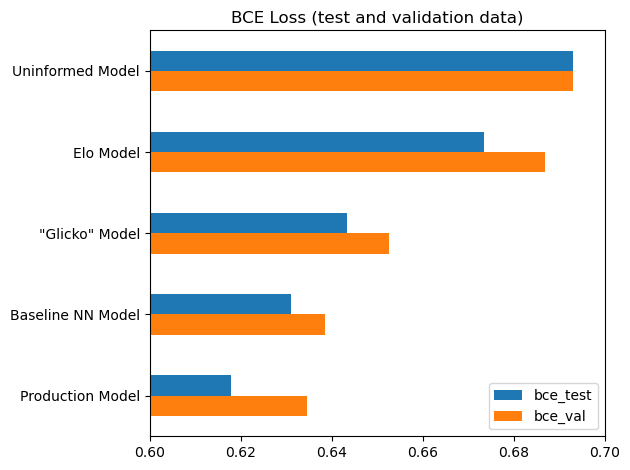

In [118]:
df.drop(index='Null Model').plot(x="model_name", y=["bce_test", "bce_val"], kind="barh", xlim=(.6,.7), ylabel='',
                                title='BCE Loss (test and validation data)')
plt.gca().invert_yaxis();
plt.tight_layout();
plt.savefig('../images/bce.jpg')

Our production model has the lowest BCE on both the test and validation data.  Its BCE loss is significantly lower than that of the baseline neural network model on the *test data*, but the loss is only *slightly lower* on the validation data.  Why might this be?

### Which to use: test data scores or validation data scores?

As we can see, it is not just the neural network models that perform noticeably worse on the validation data than they do on the test data: the Elo and Glicko models also perform worse even though *these models were not trained in a way that looked at the test data*!  This suggests that our models' worse performance on the validation data than the test data is likely primarily due to random chance and not the fact that we selected so strongly for models that perform "oddly specifically well" on the test data.

Indeed, our model selection procedure hardly looked at the test data at all; we trained just a couple NN architectures at 10 or 20 epochs and selected the best performer.  This suggests that our models' true performance is probably somewhere between its performance on the test data and its performance on the training data.

Nevertheless, in all that follows, we use the validation data as the primary basis for evaluating our models.

### MAE Loss

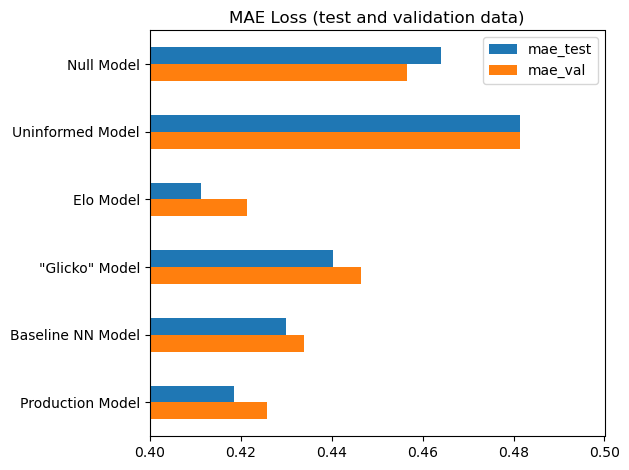

In [119]:
df.plot(x="model_name", y=["mae_test", "mae_val"], kind="barh", xlim=(.4,.5), ylabel='',
                                title='MAE Loss (test and validation data)')
plt.gca().invert_yaxis();
plt.tight_layout();
plt.savefig('../images/mae.jpg')

Our production model does not achieve quite as low of MAE loss as the Elo model does, but it does significantly better than the "Glicko" model.  This is because MAE, while being an easy-to-interpret metric, does not capture the performance of a model's probabilistic predictions as well as BCE does (at least for a problem like the one we're addressing).  Indeed, if MAE were all that mattered, then then online chess platforms might prefer the basic Elo model to the much more widely used Glicko model!

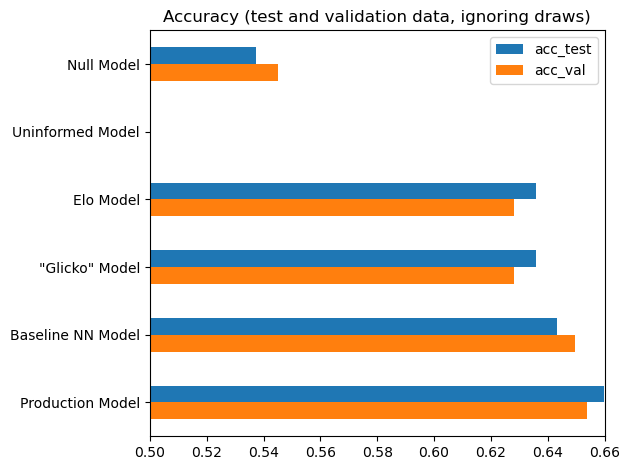

In [123]:
df.plot(x="model_name", y=["acc_test", "acc_val"], kind="barh", xlim=(.5,.66), ylabel='',
                                title='Accuracy (test and validation data, ignoring draws)')
plt.gca().invert_yaxis();
plt.tight_layout();
plt.savefig('../images/accuracy.jpg')

Yet again, our production model is the best performer, but its gains over the baseline NN model are less pronounced on the validation data than they are on the test data.

## How large of an improvement upon existing models does our model make?

In [155]:
uninformed_bce = df['bce_val']['Uninformed Model']
glicko_bce = df['bce_val']['"Glicko" Model']
baseline_bce = df['bce_val']['Baseline NN Model']
model_bce = df['bce_val']['Production Model']

baseline_improvement = (baseline_bce - glicko_bce)/(glicko_bce-uninformed_bce)
model_improvement = (model_bce - glicko_bce)/(glicko_bce-uninformed_bce)

print(f'Baseline NN model BCE improvement over "Glicko": {round(100*baseline_improvement, 2)}%')
print(f'Production model BCE improvement over "Glicko": {round(100*model_improvement, 2)}%')

Baseline NN model BCE improvement over "Glicko": 34.64%
Production model BCE improvement over "Glicko": 44.57%


The first of these numbers represents the improvement of the baseline NN model over the "Glicko" model, measured as a percentage of the improvement of the "Glicko" model over the uninformed model (the one that always predicts a 50% probability that the new player wins her 2nd game).  The second of these numbers represents the improvement of our production model over the "Glicko" model, measured on the same scale.  All scores were computed on the unused validation data.

Thus, although the *absolute* reduction in BCE loss may seem small, it is quite large when compared to the improvement of a widely-used model over completely random guessing!

### Accuracy

In [157]:
uninformed_acc = df['acc_val']['Uninformed Model']
glicko_acc = df['acc_val']['"Glicko" Model']
baseline_acc = df['acc_val']['Baseline NN Model']
model_acc = df['acc_val']['Production Model']

baseline_improvement = (baseline_acc - glicko_acc)/(glicko_acc-uninformed_acc)
model_improvement = (model_acc - glicko_acc)/(glicko_acc-uninformed_acc)

print(f'Baseline NN model accuracy improvement over "Glicko": {round(100*baseline_improvement, 2)}%')
print(f'Production model accuracy improvement over "Glicko": {round(100*model_improvement, 2)}%')

Baseline NN model accuracy improvement over "Glicko": 16.76%
Production model accuracy improvement over "Glicko": 20.0%


These improvements are not quite as large as those we found for BCE, but they are still quite large!

### Mean Absolute Error

In [158]:
uninformed_mae = df['mae_val']['Uninformed Model']
glicko_mae = df['mae_val']['"Glicko" Model']
baseline_mae = df['mae_val']['Baseline NN Model']
model_mae = df['mae_val']['Production Model']

baseline_improvement = (baseline_mae - glicko_mae)/(glicko_mae-uninformed_mae)
model_improvement = (model_mae - glicko_mae)/(glicko_mae-uninformed_mae)

print(f'Baseline NN model MAE improvement over "Glicko": {round(100*baseline_improvement, 2)}%')
print(f'Production model MAE improvement over "Glicko": {round(100*model_improvement, 2)}%')

Baseline NN model MAE improvement over "Glicko": 35.71%
Production model MAE improvement over "Glicko": 58.99%


These improvements are rather large, *especially* for the production model!  Indeed, this is one are in which our production model is particularly stronger than the baseline neural network model.

# Examining the distribution of predictions

In [144]:
#Break the dataframe up by whether the new player won, lost, or had a draw
wins = val_2nd[val_2nd['new_pl_won']==1]
losses = val_2nd[val_2nd['new_pl_won']==0]
draws = val_2nd[val_2nd['new_pl_won']==.5]

In [145]:
def model_vs_baseline(df, description, bins=50):
    #Plot the histogram we want
    baseline_preds = df['baseline_pred']
    model_preds = df['model_pred']

    plt.hist(baseline_preds, bins=bins, alpha=.5, label='Baseline P[new pl wins]');
    plt.axvline(baseline_preds.mean(), label = f"Baseline mean: {round(baseline_preds.mean(), 3)}");
    plt.hist(model_preds, bins=bins, alpha=.5, label='Model P[new pl wins]');
    plt.axvline(model_preds.mean(), color='red', label = f"Model mean: {round(model_preds.mean(), 3)}");
    
    plt.xticks(np.linspace(0,1,11));
    plt.xlim(0, 1);
    plt.ylabel("Frequency");
    plt.legend();
    plt.title(f"Model vs. Baseline NN 2nd-game predictions (validation data),\namong cases where the new player {description}");
    plt.tight_layout();
    plt.savefig(f'../images/model_vs_baseline_hist_{description}.jpg');

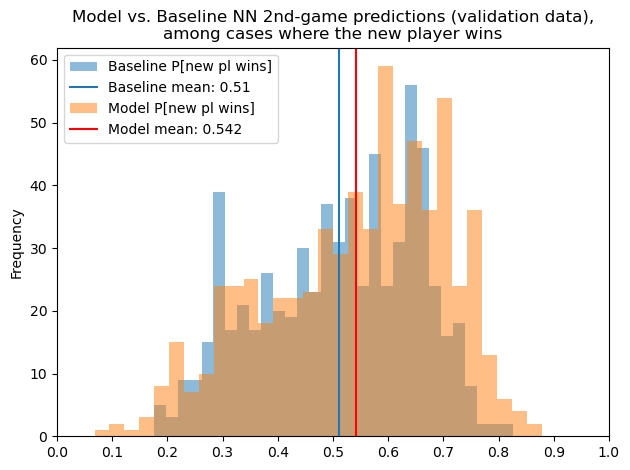

In [146]:
model_vs_baseline(wins, 'wins', bins=30)

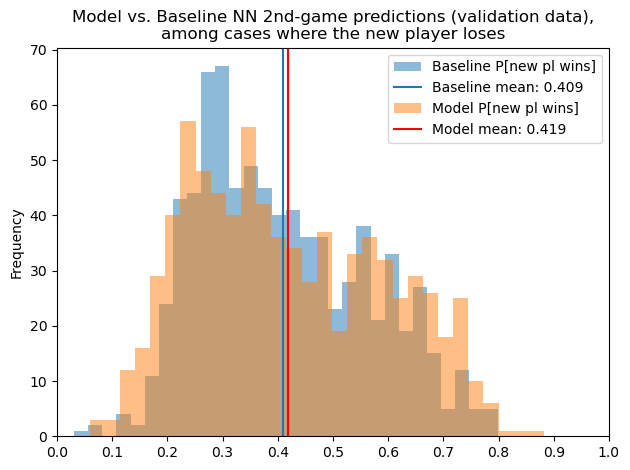

In [147]:
model_vs_baseline(losses, 'loses', bins=30)

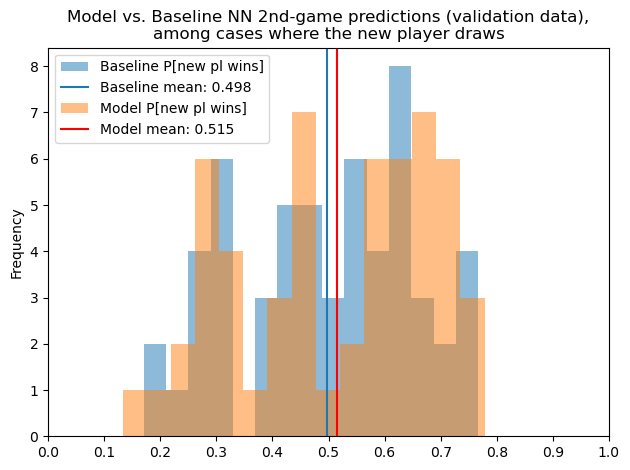

In [149]:
model_vs_baseline(draws, 'draws', bins=15)

As we can see, our production model seems to do noticeably better than the baseline NN model does in cases where the new player *wins* her 2nd game.  However, it does slightly worse among the other cases.  Since the production model is more accurate overall, this suggests that the baseline NN model's predictions are generally biased towards the new player *losing* her 2nd game (which is in fact the more common outcome, occuring 53.7% of the time among non-drawn 2nd games), while the production model is able to look into the new player's moves and positions and pick up (a little bit) on the new player's skill (when it exists).

# Conclusions

Artifical intelligence techniques can significantly improve our ability to probabilistically predict the outcomes of chess games among new players.  These improved predictions are likely to yield better matchmaking for new players, as an algorithm can search for matches where the probability of either player winning is close to 50%.

Our production model represents a significant improvement over existing models.  Consider the "Glicko" model - we use quotation marks since we can't perfectly replicate its predictions with the available data.  (We find the optimal *average* ratings deviation rather than having access to per-player ratings deviation data, but if the necessary data were available then we could incorporate them not only into a proper Glicko model but also into a version of our production model.)  This "Glicko" model represents a large improvement over the "uninformed" model - the one that always predicts that either player has a 50% chance to win - in terms of BCE loss, MAE loss and accuracy score.  However, our production model achieves:

- An additional reduction in BCE loss that is 44.6% as large as the original improvement made by the "Glicko" model,
- An additional reduction in MAE loss that is 59.0% as large as the original improvement made by the "Glicko" model, and
- An additional incrase in Accuracy score that is 20.0% as large as the original improvement made by the Glicko model.

This last mention of Glicko does not need quotation marks, as we *can* perfectly replicate the *binary* predictions made by the Glicko model used by Lichess.org.  Thus, this Accuracy improvement is one way in which our production model *definitively* improves upon a state-of-the-art model.

Our production model employs two artifical intelligence techniques that widely-used models such as Elo and Glicko do not employ: it uses chess engine evaluations of *positions and moves* in players' past games (and not just metadata about those games), and it uses a neural network to make predictions.  In this simple proof-of-concept project, the majority of our production model's improvements over existing models are achieved through the introduction of a neural network and *not* by looking at the players' moves.  Indeed, the analogous "additional improvements over Glicko" made by the baseline neural network model (that does not look at move data) are 34.6% for BCE, 35.7% for MAE, and 16.8% for accuracy.  However, with a more advanced production model that incorporates *multiple* games' worth of move data from new players, one might expect the production model to achieve larger improvements over the baseline neural network model.

# Ideas for future work

In a future project, our production model could likely be improved by incorporating move data from more than *just one game* played by a new player.  For example, using real-time data from Lichess.org, one could track new players' moves in their first *few dozen* games and continuously feed these data into Stockfish and then to a more advanced version of our production model.  The model could make updated predictions in real time and be used to find good matches for the new players.

One could in theory also track the moves of *all* existing players and use their move data to make better predictions and matches for *all* players, not just the new players.  However, this would get rather computationally expensive, and it stands to reason that the gains from employing move data would diminish after players have played many games and their ratings scores become fairly reliable measures of their skill levels.

Additionally, one could try changing several of the parameters or modeling techniques we employed.  For example, when extracting goodness scores from move data, one could break chess games into *twentieths* rather than tenths, and one could look at more than just the top 10 moves available.  One could even not break the game into "stages" at all and just use each individual board position and move, but this would introduce many more parameters and would likely require significantly more data than we obtained for this project.